In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.utils import read_csv_from_google_drive

## Исследуем датасеты

### 1 olist_customers_dataset

In [99]:
url = 'https://drive.google.com/file/d/11Uh7UtnKZcIpVSPEaiJUeZGuQxaK0iCQ/view?usp=share_link'
customers = read_csv_from_google_drive(url)
customers.shape

(99441, 5)

In [100]:
"""
customer_id	 - id покупки 
customerunique_id - id покупателя
customer_zip_code_prefix - позволяет подтянуть широту и долготу
"""
customers.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [101]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [102]:
customers.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [103]:
""" Удалим лишнее """
customers = customers.drop('customer_unique_id', axis=1)

### 2 olist_geolocation_dataset

In [104]:
geo = read_csv_from_google_drive(
    'https://drive.google.com/file/d/1jk6ZSwid6Q2hZVSfyDpIVjPhgHvoTVOa/view?usp=share_link')
geo.shape

(1000163, 5)

In [105]:
geo.head(5)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [106]:
"""
тут странность, связное поле, через которое можно смерджить данные имеет разные показатели широты и долготы
"""

geo.nunique()

geolocation_zip_code_prefix     19015
geolocation_lat                717358
geolocation_lng                717613
geolocation_city                 8011
geolocation_state                  27
dtype: int64

In [107]:
"""
пример:
"""

geo[geo.geolocation_zip_code_prefix == 1037].head(5)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
14,1037,-23.545187,-46.637855,são paulo,SP
31,1037,-23.546705,-46.640336,são paulo,SP
169,1037,-23.543883,-46.638075,são paulo,SP
178,1037,-23.546157,-46.639885,sao paulo,SP


In [108]:
"""
Чтобы убрать разбег по широте/долготе, усредним их в рамках одного зип кода
Отсальные поля нам не нужны (в более чистом виде есть в датасете customer)

Переименуем столбец zip кодов для быстрого мерджа
"""

geo = geo.groupby('geolocation_zip_code_prefix', 
            as_index=False).agg({'geolocation_lat': 'mean', 
                                 'geolocation_lng': 'mean'
                                })
geo.columns = ['customer_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']
geo.head()

,customer_zip_code_prefix,geolocation_lat,geolocation_lng
0,1001,-46.634024,-23.550190
1,1002,-46.634979,-23.548146
2,1003,-46.635731,-23.548994
3,1004,-46.634757,-23.549799
4,1005,-46.636733,-23.549456


### 3 olist_order_items_dataset

In [109]:
items = read_csv_from_google_drive(
    'https://drive.google.com/file/d/17Z6XpAixItfUK13uCYJLZYeIw7CauJ0F/view?usp=share_link')
items.shape

(112650, 7)

In [110]:
"""
отсюда взять кол-во товаров в заказе и product_id, остальное не нужно
"""

items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [111]:
"""
order_item_id агрегировать по count()
в примере видим счетчик:
"""

items[items.order_id == '00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


In [112]:
"""
Удалим лишнее и преобразуем имя order_item_id в кол-во товаров в заказе
"""

items = items.drop(['seller_id',
       'shipping_limit_date', 'price', 'freight_value'], axis=1)

items = items.groupby(['order_id', 'product_id'], as_index = False).agg({'order_item_id': 'count'})
items.columns = ['order_id', 'product_id', 'order_items_quant']
items.head()

,order_id,product_id,order_items_quant
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,1
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,1
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,1
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,1


### 4 olist_order_payments_dataset

In [113]:
payments = read_csv_from_google_drive(
    'https://drive.google.com/file/d/10ZtyuDKBewSzP0a7w4UP3xSNognc680b/view?usp=share_link')
payments.shape

(103886, 5)

In [114]:
"""
возможно, интересна сумма, если нет в другом месте
payment_type - карточки и предварит контракт boleto( не знаю, что это, вероятно оплата по счету)
payment_sequential и payment_installments тоже непонятно
"""

payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [115]:
payments.nunique()

order_id                99440
payment_sequential         29
payment_type                5
payment_installments       24
payment_value           29077
dtype: int64

In [116]:
"""
Удалим лишнее
"""
payments = payments.drop(['payment_sequential', 'payment_type',
       'payment_installments'], axis=1)
payments.head()

,order_id,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,65.71
3,ba78997921bbcdc1373bb41e913ab953,107.78
4,42fdf880ba16b47b59251dd489d4441a,128.45


### 5 olist_order_reviews_dataset

In [117]:
reviews = read_csv_from_google_drive(
    'https://drive.google.com/file/d/1pXKmappMdD4B1iVHW92SmzqC0WoK5Bqn/view?usp=share_link')
reviews.shape

(99224, 7)

In [118]:
"""
МОжно было бы дополнительно построить зависимость скора отзыва от погоды во время его написания
Но как будто это уже через чур
Поэтому исключим эти данные из рассмотрения как лишние
"""

reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


### 6 olist_orders_dataset

In [119]:
orders = read_csv_from_google_drive(
    'https://drive.google.com/file/d/1tkRj4DP1MgyOkF4-9M29abC-LZTta-V_/view?usp=share_link')
orders.shape

(99441, 8)

In [120]:
"""
Удалить все кроме order_id, customer_id, order_purchase_timestamp
Расшифровка дальше
"""

orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [121]:
orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [122]:
"""
Возможно, стоит удалить canceled         625
Но на таком объеме кажется непринципиальным, проще просто удалить признак
"""

orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [123]:
"""
Удаляем лишнее
"""
orders = orders.drop(['order_status',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'], axis=1)
orders.head()

,order_id,customer_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39


### 7 olist_products_dataset

In [124]:
products = read_csv_from_google_drive(
    'https://drive.google.com/file/d/1nKQrYG-q3vEa7hqQJ1vGhbhMgiPXHyop/view?usp=share_link')
products.shape

(32951, 9)

In [125]:
"""
Удалить все кроме product_id и product_category_name
product_category_name - поменять на английский 

"""

products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [126]:
"""
Удаляем лишнее
"""
products = products.drop(['product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'], axis=1)
products.head()

,product_id,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria
1,3aa071139cb16b67ca9e5dea641aaa2f,artes
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer
3,cef67bcfe19066a932b7673e239eb23d,bebes
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas


In [127]:
products.isnull().sum()

product_id                 0
product_category_name    610
dtype: int64

In [128]:
"""
Заполним пустышки значением unknown
"""

products = products.fillna('unknown')

In [129]:
"""
Подгрузим справочник переводов категорий
Далее сольем его с products и оставим английские названия
"""
product_category_name = read_csv_from_google_drive(
    'https://drive.google.com/file/d/1y4I0Nsivzg9Egcn2P8lsoLcN6ymOJTou/view?usp=share_link')
product_category_name.shape

(71, 2)

In [130]:
product_category_name.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [131]:
products = products.merge(product_category_name,
              on='product_category_name',
              how='left')
products.head()

,product_id,product_category_name,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,housewares


In [132]:
"""
Не все переводы в наличии
"""

products.isnull().sum()

product_id                         0
product_category_name              0
product_category_name_english    623
dtype: int64

In [133]:
products[products.product_category_name_english.isnull() == True].product_category_name.value_counts()

unknown                                          610
portateis_cozinha_e_preparadores_de_alimentos     10
pc_gamer                                           3
Name: product_category_name, dtype: int64

In [134]:
"""
Присвоим пустым значениям значения на португальском, переведем на английский
"""
products.loc[(products.product_category_name_english.isnull() == True), 'product_category_name_english'] = \
    products.loc[(products.product_category_name_english.isnull() == True), 'product_category_name']
products.loc[(products.product_category_name_english == 'portateis_cozinha_e_preparadores_de_alimentos'), 
             'product_category_name_english'] = 'kitchen_cooking_furniture'

In [135]:
"""
Удалим лишнюю колонку, получим финальный датасет 
"""
products = products.drop('product_category_name', axis=1)
products.head()

,product_id,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,art
2,96bd76ec8810374ed1b65e291975717f,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,baby
4,9dc1a7de274444849c219cff195d0b71,housewares


### 8 olist_sellers_dataset

In [136]:
sellers = read_csv_from_google_drive(
    'https://drive.google.com/file/d/1zaS11XKuOLDh4DanQT4kt_MTS3U19Ff8/view?usp=share_link')
sellers.shape

(3095, 4)

In [137]:
"""
Здесь полезных данных нет, его не используем
"""
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


### 9 Объединяем все полезные фичи в единый датасет

In [138]:
"""
Проверяем, какие фичи остались
"""
full_list = list(customers.columns) + list(geo.columns) + list(items.columns) + list(payments.columns) +list(orders.columns) + list(products.columns)
dic = {}
for i in full_list:
    dic[i] = dic.get(i, 0) + 1
dic

{'customer_city': 1,
 'customer_id': 2,
 'customer_state': 1,
 'customer_zip_code_prefix': 2,
 'geolocation_lat': 1,
 'geolocation_lng': 1,
 'order_id': 3,
 'order_items_quant': 1,
 'order_purchase_timestamp': 1,
 'payment_value': 1,
 'product_category_name_english': 1,
 'product_id': 2}

In [139]:
"""
Cлить по порядку:
1) customers и geo
2) items и products
3) orders и payments
4) orders и customers
5) orders и items

6) Удалить артефактные столбцы
"""

'\nC\xd0\xbb\xd0\xb8\xd1\x82\xd1\x8c \xd0\xbf\xd0\xbe \xd0\xbf\xd0\xbe\xd1\x80\xd1\x8f\xd0\xb4\xd0\xba\xd1\x83:\n1) customers \xd0\xb8 geo\n2) items \xd0\xb8 products\n3) orders \xd0\xb8 payments\n4) orders \xd0\xb8 customers\n5) orders \xd0\xb8 items\n\n6) \xd0\xa3\xd0\xb4\xd0\xb0\xd0\xbb\xd0\xb8\xd1\x82\xd1\x8c \xd0\xb0\xd1\x80\xd1\x82\xd0\xb5\xd1\x84\xd0\xb0\xd0\xba\xd1\x82\xd0\xbd\xd1\x8b\xd0\xb5 \xd1\x81\xd1\x82\xd0\xbe\xd0\xbb\xd0\xb1\xd1\x86\xd1\x8b\n'

In [140]:
"""
1) Объединяем customers и geo
"""
customers = customers.merge(geo,
              on='customer_zip_code_prefix',
              how='left')

In [141]:
customers.isnull().sum()

customer_id                   0
customer_zip_code_prefix      0
customer_city                 0
customer_state                0
geolocation_lat             278
geolocation_lng             278
dtype: int64

In [142]:
"""
Восстановим долготу и широту по среднегородской
"""

city_lst = list(customers.loc[(customers.geolocation_lat.isnull() == True)].customer_city.unique())
for city in city_lst:
    customers.loc[(customers.customer_city == city) & (customers.geolocation_lat.isnull() == True), 'geolocation_lat'] = \
        customers.loc[customers.customer_city == city].geolocation_lat.mean()
    customers.loc[(customers.customer_city == city) & (customers.geolocation_lng.isnull() == True), 'geolocation_lng'] = \
        customers.loc[customers.customer_city == city].geolocation_lng.mean()    
customers.isnull().sum()

customer_id                  0
customer_zip_code_prefix     0
customer_city                0
customer_state               0
geolocation_lat             52
geolocation_lng             52
dtype: int64

In [143]:
"""
Оставшихся городов не оказалось в системе, удалим их, 
поскольку усреднение в рамках штата может сделать прогноз неадекватным
"""
customers = customers.dropna(how='any', axis=0)
customers.head()

,customer_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng
0,06b8999e2fba1a1fbc88172c00ba8bc7,14409,franca,SP,-47.396929,-20.498489
1,18955e83d337fd6b2def6b18a428ac77,9790,sao bernardo do campo,SP,-46.542848,-23.727992
2,4e7b3e00288586ebd08712fdd0374a03,1151,sao paulo,SP,-46.656289,-23.531642
3,b2b6027bc5c5109e529d4dc6358b12c3,8775,mogi das cruzes,SP,-46.185233,-23.499702
4,4f2d8ab171c80ec8364f7c12e35b23ad,13056,campinas,SP,-47.142925,-22.975100


In [144]:
"""
2) Объединяем items и products
"""
items = items.merge(products,
              on='product_id',
              how='left')

items.isnull().sum()

order_id                         0
product_id                       0
order_items_quant                0
product_category_name_english    0
dtype: int64

In [145]:
"""
3) Объединяем orders и payments
"""
orders = orders.merge(payments,
              on='order_id',
              how='left')
orders.isnull().sum()

order_id                    0
customer_id                 0
order_purchase_timestamp    0
payment_value               1
dtype: int64

In [146]:
"""
Заполним средним значением пропущенную сумму
"""
orders['payment_value'] = orders['payment_value'].fillna(orders.payment_value.mean())
orders.head()

,order_id,customer_id,order_purchase_timestamp,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,179.12


In [147]:
"""
4) Объединяем orders и customers
"""
orders = orders.merge(customers,
            on='customer_id',
            how='left')
orders.isnull().sum()

order_id                     0
customer_id                  0
order_purchase_timestamp     0
payment_value                0
customer_zip_code_prefix    53
customer_city               53
customer_state              53
geolocation_lat             53
geolocation_lng             53
dtype: int64

In [148]:
"""
Удалим строки, где отсутствуют данные по координатам,
поскольку эти данные для нас критичны
"""
orders = orders.dropna(how='any', axis=0)
orders.head()

,order_id,customer_id,order_purchase_timestamp,payment_value,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,18.12,3149.0,sao paulo,SP,-46.587161,-23.576983
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2.00,3149.0,sao paulo,SP,-46.587161,-23.576983
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,18.59,3149.0,sao paulo,SP,-46.587161,-23.576983
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,141.46,47813.0,barreiras,BA,-44.660711,-12.177924
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,179.12,75265.0,vianopolis,GO,-48.514783,-16.745150


In [149]:
"""
5) Объединяем orders и customers
"""
orders = orders.merge(items,
            on='order_id',
            how='left')
orders.isnull().sum()

order_id                           0
customer_id                        0
order_purchase_timestamp           0
payment_value                      0
customer_zip_code_prefix           0
customer_city                      0
customer_state                     0
geolocation_lat                    0
geolocation_lng                    0
product_id                       829
order_items_quant                829
product_category_name_english    829
dtype: int64

In [150]:
"""
Заполним пустые строки значением 'unknown'
"""
orders['order_items_quant'] = orders['order_items_quant'].fillna(1)
orders = orders.fillna('unknown')
orders.head()

,order_id,customer_id,order_purchase_timestamp,payment_value,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,product_id,order_items_quant,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,18.12,3149.0,sao paulo,SP,-46.587161,-23.576983,87285b34884572647811a353c7ac498a,1.0,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2.00,3149.0,sao paulo,SP,-46.587161,-23.576983,87285b34884572647811a353c7ac498a,1.0,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,18.59,3149.0,sao paulo,SP,-46.587161,-23.576983,87285b34884572647811a353c7ac498a,1.0,housewares
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,141.46,47813.0,barreiras,BA,-44.660711,-12.177924,595fac2a385ac33a80bd5114aec74eb8,1.0,perfumery
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,179.12,75265.0,vianopolis,GO,-48.514783,-16.745150,aa4383b373c6aca5d8797843e5594415,1.0,auto


In [151]:
"""
6) Удалим артефакты, переименуем признаки для удобства
"""
orders = orders.drop(['order_id', 'customer_id', 'product_id'], axis=1)

orders.columns = ['timestamp', 'payment_value', 'zip_code',
       'city', 'state', 'latitude', 'longitude',
       'items_quant', 'product_category']

orders.head()

,timestamp,payment_value,zip_code,city,state,latitude,longitude,items_quant,product_category
0,2017-10-02 10:56:33,18.12,3149.0,sao paulo,SP,-46.587161,-23.576983,1.0,housewares
1,2017-10-02 10:56:33,2.00,3149.0,sao paulo,SP,-46.587161,-23.576983,1.0,housewares
2,2017-10-02 10:56:33,18.59,3149.0,sao paulo,SP,-46.587161,-23.576983,1.0,housewares
3,2018-07-24 20:41:37,141.46,47813.0,barreiras,BA,-44.660711,-12.177924,1.0,perfumery
4,2018-08-08 08:38:49,179.12,75265.0,vianopolis,GO,-48.514783,-16.745150,1.0,auto


### 10 Разберемся с временным рядом

In [152]:
"""
Пока непонятна история с часовыми поясами
"""
orders.timestamp = pd.to_datetime(orders.timestamp)

In [153]:
orders['date'] = orders.timestamp.dt.date
orders['time'] = orders.timestamp.dt.time
orders['weekday'] = orders.timestamp.dt.day_name()

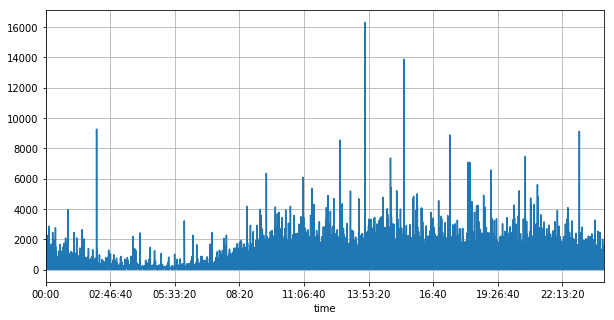

In [154]:
"""
График суточной активности вполне соответствует норме
Скорее всего время приведено к местному
"""
orders.groupby('time').payment_value.sum().plot(kind='line', figsize=(10,5), grid=True);

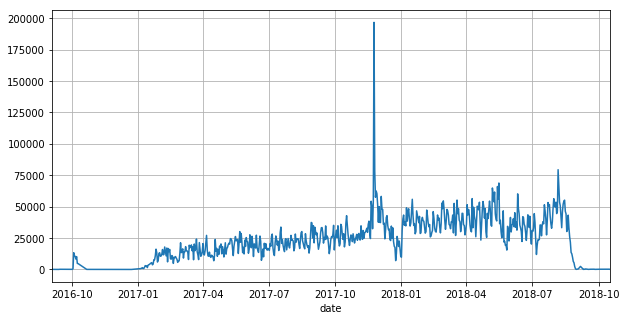

In [155]:
"""
График продаж по дням
Есть странная аномалия в конце 2017 года, надо проверить
"""
orders.groupby('date').payment_value.sum().plot(kind='line', figsize=(10,5), grid=True);

In [156]:
"""
Праздничные дни

                                    ['2016-09-07',
                                     '2016-10-12',
                                     '2016-11-02',
                                     '2016-11-15',
                                     '2016-12-25',
                                     '2016-12-31',
                                     '2017-01-01',
                                     '2017-02-27',                                     
                                     '2017-02-28',
                                     '2017-03-01',
                                     '2017-04-14', 
                                     '2017-04-21', 
                                     '2017-05-01',
                                     '2017-06-15',                                     
                                     '2017-09-07',
                                     '2017-10-12',
                                     '2017-11-01',
                                     '2017-11-02',
                                     '2017-11-15',
                                     '2017-12-20',
                                     '2017-12-25',
                                     '2018-01-01',
                                     '2018-02-12',                                     
                                     '2018-02-13',
                                     '2018-03-01',
                                     '2018-03-30', 
                                     '2018-04-21', 
                                     '2018-05-01',
                                     '2018-05-31',                                     
                                     '2018-09-07',
                                     '2018-10-12']

Надо учесть праздничные дни
"""
orders.shape

(107802, 12)

In [157]:
orders.to_csv('output_data/orders.csv', index=False)